In [44]:
library("gRain")
library("Rgraphviz")
library("dagitty")
library("bnlearn")
library("pcalg")
library("dplyr")

In [38]:
setwd("/Users/lisa/Documents/Uni/03.SemesterMaster/BN/bn17")
d <- read.table(header=T, sep=",", 'adult_cleaned.csv')
d[d=="?"]<-NA
d <- d[complete.cases(d),]
d <- data.frame(d)

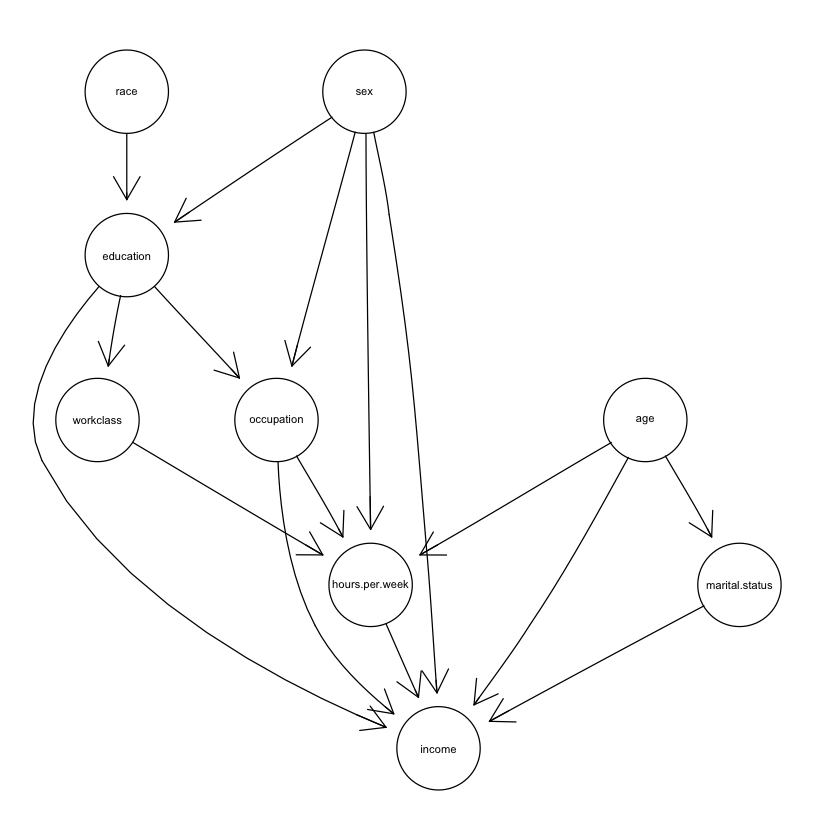

In [19]:
our_network <- dag(~ race + education:race:sex + workclass:education + hours.per.week:workclass:occupation:age:sex + occupation:education:sex + marital.status:age + income:age:sex:occupation:hours.per.week:education:marital.status)
plot(our_network)

In [32]:
## Load data
V <- colnames(d)

In [55]:
# age 8
# workclass 7
# education 6
# marital.status 7
# occupation 6
# race 5
# sex 2
# hours.per.week 6
# native.country 2
# income 2

In [56]:
## define sufficient statistics
suffStat <- list(dm = d, nlev = c(8,7,6,7,6,5,2,6,2,2), adaptDF = FALSE)

In [58]:
## estimate CPDAG
pc.D <- pc(suffStat,
           ## independence test: G^2 statistic
           indepTest = disCItest, alpha = 0.01, labels = V, verbose = TRUE)

Order=0; remaining edges:90
x= 1  y= 2  S=  : pval = 0 
x= 1  y= 3  S=  : pval = 9.944734e-299 
x= 1  y= 4  S=  : pval = 0 
x= 1  y= 5  S=  : pval = 1.003792e-190 
x= 1  y= 6  S=  : pval = 4.206252e-11 
x= 1  y= 7  S=  : pval = 1.196726e-77 
x= 1  y= 8  S=  : pval = 0 
x= 1  y= 9  S=  : pval = 2.699078e-11 
x= 1  y= 10  S=  : pval = 0 
x= 2  y= 1  S=  : pval = 0 
x= 2  y= 3  S=  : pval = 3.010285e-289 
x= 2  y= 4  S=  : pval = 2.450515e-213 
x= 2  y= 5  S=  : pval = 0 
x= 2  y= 6  S=  : pval = 2.320825e-77 
x= 2  y= 7  S=  : pval = 2.244287e-151 
x= 2  y= 8  S=  : pval = 0 
x= 2  y= 9  S=  : pval = 6.724318e-18 
x= 2  y= 10  S=  : pval = 3.200481e-151 
x= 3  y= 1  S=  : pval = 9.944734e-299 
x= 3  y= 2  S=  : pval = 3.010285e-289 
x= 3  y= 4  S=  : pval = 2.179943e-124 
x= 3  y= 5  S=  : pval = 0 
x= 3  y= 6  S=  : pval = 1.724322e-69 
x= 3  y= 7  S=  : pval = 6.466414e-30 
x= 3  y= 8  S=  : pval = 8.099147e-140 
x= 3  y= 9  S=  : pval = 2.488268e-229 
x= 3  y= 10  S=  : pval = 0 
x= 4

Warning message in gSquareDis(x = x, y = y, S = S, dm = dm, nlev = nlev, adaptDF = adaptDF, :
“n=30162 is too small (n < n.min = 30240 ) for G^2 test (=> treated as independence)”

x= 1  y= 4  S= 3 8 10 : pval = 1 
x= 1  y= 8  S= 3 4 10 : pval = 2.837294e-51 
x= 1  y= 10  S= 3 4 8 : pval = 1 
x= 2  y= 5  S= 7 8 10 : pval = 0 
x= 2  y= 7  S= 5 8 10 : pval = 2.015939e-42 
x= 2  y= 8  S= 5 7 10 : pval = 7.75569e-162 
x= 2  y= 10  S= 5 7 8 : pval = 6.839356e-16 
x= 3  y= 5  S= 1 7 8 : pval = 0 
x= 3  y= 5  S= 1 7 9 : pval = 0 
x= 3  y= 5  S= 1 7 10 : pval = 0 
x= 3  y= 5  S= 1 8 9 : pval = 0 
x= 3  y= 5  S= 1 8 10 : pval = 0 
x= 3  y= 5  S= 1 9 10 : pval = 0 
x= 3  y= 5  S= 7 8 9 : pval = 0 
x= 3  y= 5  S= 7 8 10 : pval = 0 
x= 3  y= 5  S= 7 9 10 : pval = 0 
x= 3  y= 5  S= 8 9 10 : pval = 0 
x= 3  y= 7  S= 1 5 8 : pval = 1 
x= 3  y= 8  S= 1 5 7 : pval = 1 
x= 3  y= 9  S= 1 5 7 : pval = 3.556896e-105 
x= 3  y= 9  S= 1 5 8 : pval = 4.878722e-09 
x= 3  y= 9  S= 1 5 10 : pval = 7.473721e-96 
x= 3  y= 9  S= 1 7 8 : pval = 7.031743e-128 
x= 3  y= 9  S= 1 7 10 : pval = 5.110673e-197 
x= 3  y= 9  S= 1 8 10 : pval = 8.534514e-117 
x= 3  y= 9  S= 5 7 8 : pval = 6.275226e-106 


Warning message in gSquareDis(x = x, y = y, S = S, dm = dm, nlev = nlev, adaptDF = adaptDF, :
“n=30162 is too small (n < n.min = 102900 ) for G^2 test (=> treated as independence)”

x= 8  y= 1  S= 2 3 4 : pval = 1 


Warning message in gSquareDis(x = x, y = y, S = S, dm = dm, nlev = nlev, adaptDF = adaptDF, :
“n=30162 is too small (n < n.min = 100800 ) for G^2 test (=> treated as independence)”

x= 8  y= 2  S= 1 3 4 : pval = 1 


Warning message in gSquareDis(x = x, y = y, S = S, dm = dm, nlev = nlev, adaptDF = adaptDF, :
“n=30162 is too small (n < n.min = 100800 ) for G^2 test (=> treated as independence)”

x= 8  y= 4  S= 1 2 3 : pval = 1 


Warning message in gSquareDis(x = x, y = y, S = S, dm = dm, nlev = nlev, adaptDF = adaptDF, :
“n=30162 is too small (n < n.min = 84000 ) for G^2 test (=> treated as independence)”

x= 8  y= 5  S= 1 2 3 : pval = 1 
x= 8  y= 7  S= 1 2 3 : pval = 9.04003e-32 
x= 8  y= 7  S= 1 2 4 : pval = 0.2664647 
x= 8  y= 10  S= 1 2 3 : pval = 0.9026042 
x= 10  y= 2  S= 1 3 4 : pval = 1 
x= 10  y= 3  S= 1 2 4 : pval = 3.59621e-58 
x= 10  y= 3  S= 1 2 5 : pval = 3.12734e-09 
x= 10  y= 3  S= 1 2 7 : pval = 1.832366e-291 
x= 10  y= 3  S= 1 2 8 : pval = 3.241738e-63 
x= 10  y= 3  S= 1 4 5 : pval = 0.07335737 
x= 10  y= 4  S= 1 2 3 : pval = 4.818737e-258 
x= 10  y= 4  S= 1 2 5 : pval = 8.65925e-299 
x= 10  y= 4  S= 1 2 7 : pval = 0 
x= 10  y= 4  S= 1 2 8 : pval = 6.378931e-202 
x= 10  y= 4  S= 1 3 5 : pval = 0 
x= 10  y= 4  S= 1 3 7 : pval = 0 
x= 10  y= 4  S= 1 3 8 : pval = 1.280192e-270 
x= 10  y= 4  S= 1 5 7 : pval = 0 
x= 10  y= 4  S= 1 5 8 : pval = 0 
x= 10  y= 4  S= 1 7 8 : pval = 0 
x= 10  y= 4  S= 2 3 5 : pval = 0 
x= 10  y= 4  S= 2 3 7 : pval = 0 
x= 10  y= 4  S= 2 3 8 : pval = 0 
x= 10  y= 4  S= 2 5 7 : pval = 0 
x= 10  y= 4  S= 2 5 8 : pval = 0 
x= 10  y= 4  S= 2 7 8 : pval

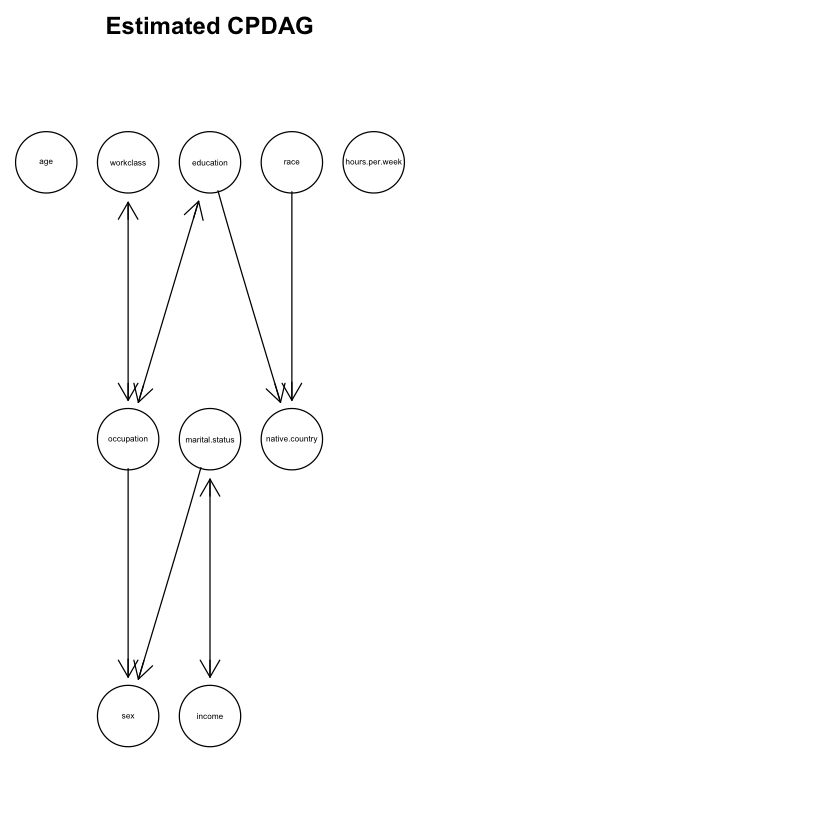

In [59]:
if (require(Rgraphviz)) {
  ## show estimated CPDAG
  par(mfrow = c(1,2))
  plot(pc.D, main = "Estimated CPDAG")
}